In [ ]:
import os
import numpy as np
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import random

from google.colab import drive
# Connect Google Colab to Google Drive
drive.mount('/content/drive')

# Directory containing the dataset
data_dir ='/content/drive/My Drive/totalall/'

# Get all paths to images in the directory
images_paths = [os.path.join(data_dir, file) for file in os.listdir(data_dir) if file.endswith(('.jpg', '.png', '.jpeg'))]

# Define target size
target_size = (224, 224)  # Size required for ResNet50 model input

# Function to process images
def process_image(image_path):
    img = Image.open(image_path).convert('RGB')  # Ensure image has three channels (RGB)
    width, height = img.size
    if width > height:
        # Apply Center Cropping
        left = (width - height) / 2
        right = (width + height) / 2
        img = img.crop((left, 0, right, height))
    else:
        # Apply Padding
        padding = (0, (height - width) // 2, 0, (height - width) // 2)
        img = ImageOps.expand(img, padding)

    img = img.resize(target_size)  # Resize image to target size
    img = np.array(img) / 255.0  # Normalize image
    return img

# Split paths into training and testing sets
train_paths, test_paths = train_test_split(images_paths, test_size=0.2, random_state=42)

# Dummy labels (replace with actual labels)
num_classes = 5
train_labels = np.random.randint(0, num_classes, size=(len(train_paths),))
test_labels = np.random.randint(0, num_classes, size=(len(test_paths),))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Data generator setup with data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Custom function to generate data
def custom_generator(image_paths, labels, batch_size):
    num_samples = len(image_paths)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_paths = image_paths[offset:offset + batch_size]
            batch_labels = labels[offset:offset + batch_size]

            batch_images = [process_image(path) for path in batch_paths]
            batch_images = np.array(batch_images)

            yield batch_images, batch_labels

batch_size = 32
train_generator = custom_generator(train_paths, train_labels, batch_size)
test_generator = custom_generator(test_paths, test_labels, batch_size)


1/1 [==============================] - 5s 5s/step
Epoch 1/10
135/135 [==============================] - 5s 29ms/step - loss: 1.7482 - accuracy: 0.1905 - val_loss: 1.7164 - val_accuracy: 0.1932
Epoch 2/10
135/135 [==============================] - 5s 34ms/step - loss: 1.6507 - accuracy: 0.2086 - val_loss: 1.6388 - val_accuracy: 0.1847
Epoch 3/10
135/135 [==============================] - 3s 25ms/step - loss: 1.6331 - accuracy: 0.2215 - val_loss: 1.6381 - val_accuracy: 0.1894
Epoch 4/10
135/135 [==============================] - 3s 25ms/step - loss: 1.6333 - accuracy: 0.2058 - val_loss: 1.6147 - val_accuracy: 0.1913
Epoch 5/10
135/135 [==============================] - 4s 28ms/step - loss: 1.6133 - accuracy: 0.2046 - val_loss: 1.6139 - val_accuracy: 0.2131
Epoch 6/10
135/135 [==============================] - 5s 35ms/step - loss: 1.6108 - accuracy: 0.1977 - val_loss: 1.6135 - val_accuracy: 0.2045
Epoch 7/10
135/135 [==============================] - 3s 25ms/step - loss: 1.6108 - accuracy

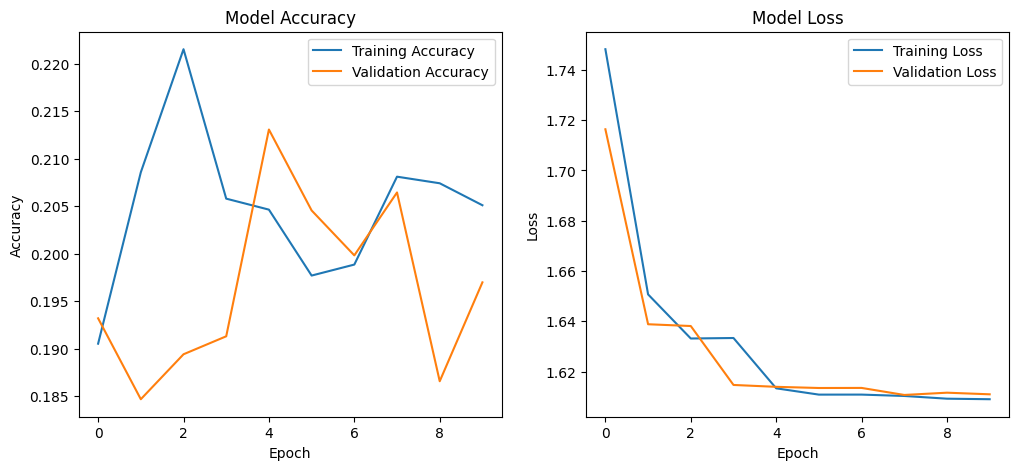

In [ ]:
# Load pre-trained ResNet50 model without top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Extract features using GlobalAveragePooling2D layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
features_extraction_model = Model(inputs=base_model.input, outputs=x)

# Prepare training and testing data for use with feature extraction
train_features = []
train_labels_list = []
for _ in range(len(train_paths) // batch_size):
    images, labels = next(train_generator)
    features = features_extraction_model.predict(images)
    train_features.append(features)
    train_labels_list.append(labels)
train_features = np.vstack(train_features)
train_labels = np.hstack(train_labels_list)

test_features = []
test_labels_list = []
for _ in range(len(test_paths) // batch_size):
    images, labels = next(test_generator)
    features = features_extraction_model.predict(images)
    test_features.append(features)
    test_labels_list.append(labels)
test_features = np.vstack(test_features)
test_labels = np.hstack(test_labels_list)

# Set up a new classification model using the extracted features
classification_model = tf.keras.Sequential([
    Dense(1024, activation='relu', input_shape=train_features.shape[1:]),
    Dense(num_classes, activation='softmax')
])

# Compile the model
classification_model.compile(optimizer='adam',
                             loss='sparse_categorical_crossentropy',
                             metrics=['accuracy'])

# Train the model
history = classification_model.fit(train_features, train_labels,
                                   epochs=10,
                                   validation_data=(test_features, test_labels))

# Evaluate the model
test_loss, test_acc = classification_model.evaluate(test_features, test_labels, verbose=2)
print(f'\nTest accuracy: {test_acc}')

# Display outputs in a graphical format
# Plot model accuracy during training and validation
plt.figure(figsize=(12, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 57ms/step


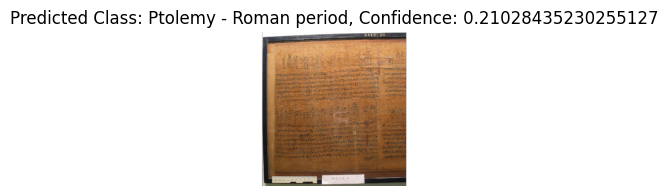

In [ ]:
# Add step to predict on a random image from the dataset and display the image and prediction
# Choose a random image
random_image_path = random.choice(images_paths)

# Function to predict on a random image
def predict_random_image(model, features_extraction_model, image_path):
    # Extract features from the image
    img = process_image(image_path)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    features = features_extraction_model.predict(img)

    # Predict using the new model
    predicted_class_probs = model.predict(features)
    predicted_class = np.argmax(predicted_class_probs)
    return predicted_class, predicted_class_probs

# Predict on the random image
predicted_class, predicted_class_probs = predict_random_image(classification_model, features_extraction_model, random_image_path)

# Display the image
plt.figure(figsize=(4, 4))
img = Image.open(random_image_path)
plt.imshow(img)
plt.axis('off')

# Display the prediction
class_labels = ['Third intermediate period', 'Ptolemy - Roman period', 'New Kingdom hieroglyphic', 'New Kingdom Hieratic', 'Late period']
plt.title(f'Predicted Class: {class_labels[predicted_class]}, Confidence: {predicted_class_probs[0][predicted_class]}')
plt.show()

1/1 [==============================] - 0s 18ms/step


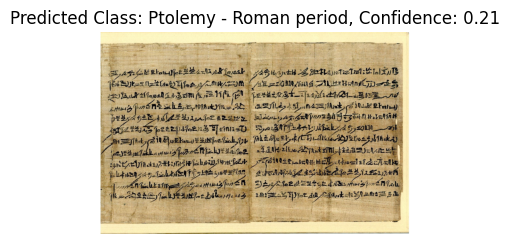

In [ ]:
# Define the actual class labels
class_labels = ['Third intermediate period', 'Ptolemy - Roman period', 'New Kingdom hieroglyphic', 'New Kingdom Hieratic', 'Late period']

# Add step to predict on a random image from the dataset and display the image and prediction
# Choose a random image
random_image_path = random.choice(images_paths)

# Function to predict on a random image
def predict_random_image(model, features_extraction_model, image_path):
    # Extract features from the image
    img = process_image(image_path)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    features = features_extraction_model.predict(img)

    # Predict using the new model
    predicted_class_probs = model.predict(features)
    predicted_class = np.argmax(predicted_class_probs)
    return predicted_class, predicted_class_probs

# Predict on the random image
predicted_class, predicted_class_probs = predict_random_image(classification_model, features_extraction_model, random_image_path)

# Display the image
plt.figure(figsize=(4, 4))
img = Image.open(random_image_path)
plt.imshow(img)
plt.axis('off')

# Display the prediction
plt.title(f'Predicted Class: {class_labels[predicted_class]}, Confidence: {predicted_class_probs[0][predicted_class]:.2f}')
plt.show()
